## Brain Tumor Detection

###Importation de la librairie

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


from imutils import paths
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import argparse
import os
import cv2

import sklearn.preprocessing as preprocessing
import pandas as pd

import random

###Chargement de la base de données
Les répertoires de l'ensemble de données "tumeur_oui" et "tumeur_non" sont conservés dans le répertoire "tumeur_cerebrale".

In [2]:
#chemin d'accès au répertoire
chemin = "./tumeur_cerebrale/"

# Vérifier que les dossiers sont chargés
dirs = os.listdir(chemin)  #Retourne une liste des noms des repertoires 


for file in dirs :
  print (file)

# Liste de tous les chemins d'images à l'intérieur du répertoire
chemin_images = list(paths.list_images(chemin))


# Vérifier le nombre d'images (= 253)
print(len(chemin_images))

# Afficher aléatoirement un chemin d'image
print(random.choice(chemin_images))



tumeur_non
tumeur_oui
.ipynb_checkpoints
253
./tumeur_cerebrale/tumeur_non/5 no.jpg


###Conversion des images en pixel
Pour obtenir de meilleurs résultats, on redimensionne la taille de pixel des images d’entrée en une taille uniforme 224×224 pixels (on va expliquer par la suite pourquoi cette taille exacte de pixels a été choisie)

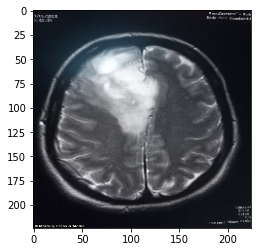

In [3]:
images = []
labels = []

for chemin_image in chemin_images:
    label = chemin_image.split(os.path.sep)[2]  # On s'interesse aux etiquettes tumeur_oui et tumeur_non

    # Convertir les images en pixel
    image = cv2.imread(chemin_image)

    # Compression des images
    image = cv2.resize(image, (224, 224))

    # Sauvegarder les données dans une liste
    images.append(image)
    labels.append(label)


# Afficher aléatoirement une image
plt.imshow(random.choice(images)) 
plt.show()

   

###Convertir les listes en arrays


In [4]:
images = np.array(images) / 255.0
labels = np.array(labels)


###Conversion du label en binaire
Les données d'entrée du label doivent êtres converties d'une façon à ce que les machines puissent les interpréter. En prenant en compte les données d'entrée, qui sont des variables catégorielles (tumeur_oui et tumeur_non), on utilise l'encodage one-hot pour convertir ces données en binaire. Une nouvelle variable binaire est alors ajoutée pour chaque valeur entière

In [5]:
data = np.array(labels)

# Convertir le label en int
labelEnc = preprocessing.LabelEncoder()
nouvelle_data = labelEnc.fit_transform(data)

# Création de l'encodeur one-hot
EncodeurOnehot = preprocessing.OneHotEncoder()


EncodeurOnehot.fit(nouvelle_data.reshape(-1, 1))
data_trans = EncodeurOnehot.transform(nouvelle_data.reshape(-1, 1))
labels = data_trans.toarray()

print("label après l'encodeur one-hot:")
print(labels[0])



label après l'encodeur one-hot:
[1. 0.]


###Division de l'ensemble de données
On divise l'ensemble de données en deux ensembles : train et test.

In [6]:
(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)


###Augmentation de données
L'augmentation de données sert à nous assurer que notre réseau aperçoit de nouvelles variations des données à chaque epoch.

Pour cela, on utilise ImageDataGenerator, cette fonction accepte les données d'origine et les transforme de manière aléatoire (translation, rotation ...). A la fin, elle génère les nouveaux échantillons d'apprentissage.

In [7]:
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)


###Création d'un modèle
Nous allons construire un modèle creé à patir d'un autre modèle pré-entraîné (apprentissage par transfert).

**Création d'un modèle à partir du modèle pré-entraîné  VGG-16**


La taille d'entrée par défaut pour ce modèle est 224x224 pixels, ce qui justifie dans ce qui précède la raison du redimensionnement des données d'entrée.

In [8]:

base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

###Geler les couches
Pour éviter le surapprentissage et la destruction de de toute information.

In [9]:
#Geler les couches à partir du modèle VGG-16
for layer in base_model.layers:
    layer.trainable = False



In [10]:
# base_model.trainable = True

# set_trainable = False
# for layer in base_model.layers:
#     if layer.name in ['block5_conv1', 'block4_conv1']:
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
        
# layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

###Compilation

In [11]:
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer='adam', metrics= ['accuracy'], loss= 'binary_crossentropy')


###Résumé

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

###Définir les paramètres

In [13]:
batch_size = 8
train_steps = len(train_X) // batch_size       #jeu de données de test
validation_steps = len(test_X) // batch_size   #jeu de données de validation
epochs = 10                                    #nombre d'itérations

###Evaluer le modèle

In [14]:
history = model.fit(train_generator.flow(train_X, train_Y, batch_size= batch_size),
                              steps_per_epoch= train_steps,
                              validation_data = (test_X, test_Y),
                              validation_steps= validation_steps,
                              epochs= epochs)

Epoch 1/10
28/28 [==============================] - 128s 5s/step - loss: 0.7194 - accuracy: 0.6027 - val_loss: 0.6580 - val_accuracy: 0.6154
Epoch 2/10
28/28 [==============================] - 127s 5s/step - loss: 0.6557 - accuracy: 0.6119 - val_loss: 0.6216 - val_accuracy: 0.6154
Epoch 3/10
28/28 [==============================] - 127s 5s/step - loss: 0.6423 - accuracy: 0.6438 - val_loss: 0.5927 - val_accuracy: 0.6538
Epoch 4/10
28/28 [==============================] - 127s 5s/step - loss: 0.6236 - accuracy: 0.6575 - val_loss: 0.5973 - val_accuracy: 0.7692
Epoch 5/10
28/28 [==============================] - 127s 5s/step - loss: 0.6104 - accuracy: 0.7078 - val_loss: 0.5575 - val_accuracy: 0.7692
Epoch 6/10
28/28 [==============================] - 126s 5s/step - loss: 0.5820 - accuracy: 0.7169 - val_loss: 0.5374 - val_accuracy: 0.7308
Epoch 7/10
28/28 [==============================] - 127s 5s/step - loss: 0.5440 - accuracy: 0.7808 - val_loss: 0.5097 - val_accuracy: 0.7692
Epoch 8/10
28

###Prédiction
On crée une matrice de confusion dont les lignes sont les classes réelles et les colonnes sont les classes estimées.

In [15]:
test_predict = model.predict(test_X, batch_size= batch_size)
test_predict = np.argmax(test_predict, axis= 1)
actuals = np.argmax(test_Y, axis= 1)
cm = confusion_matrix(actuals, test_predict)  #matrice de confusion

###Précision
Pour calculer la précision, on utilise la formule suivante :

*Précision = (TruePositive + TrueNegative) / total *

In [16]:

total = sum(sum(cm))
precision = (cm[0, 0] + cm[1, 1]) / total   #cm[0, 0] : TP , cm[1,1] : TN
print("Précision: {:.2f}".format(precision))

Précision: 0.85


###Représentation graphique du modèle

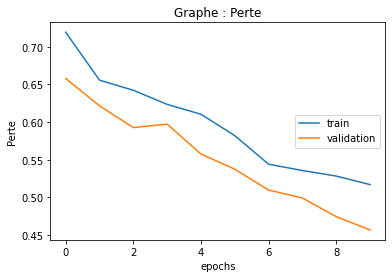

In [17]:
N = epochs
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "validation")



plt.title("Graphe : Perte")
plt.xlabel("epochs")
plt.ylabel("Perte")
plt.legend(loc= "center right")
plt.savefig("plot.jpg")

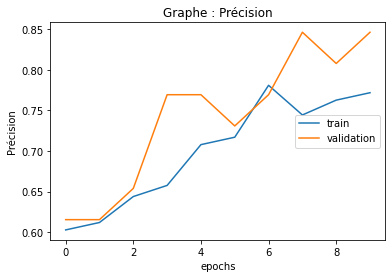

In [18]:
N = epochs
plt.figure()

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "validation")

plt.title("Graphe : Précision")
plt.xlabel("epochs")
plt.ylabel("Précision")
plt.legend(loc= "center right")
plt.savefig("plot.jpg")